**Идея текущего подзода:** Если исполнители играют внутри одних и тех же сессий, значит такие исполнители похожи.

1. Нужно для каждого исполнителя найти соседей по всем сессиям, в которых был данный исполнитель. Каждому исполнителю будет сопоставлена последовательность из его соседей за все сессии.

2. Последовательность соседей может быть преобразована:
    - в вектор, где каждый сосед по сессиям будет иметь единицу, а остальные исполнители будут иметь нули \[бинарно\];
    - в вектор, где каждый сосед по сессиям будет значение равное кол-ву сессий, в которых данные исполнитель и сосед были в одной сессии, а остальные исполнители будут иметь нули;
    - tf-idf;
3. **Но** тк исполнителей очень большое количество, получается разреженная матрица размера $N_{persons} \cdot N_{persons}$, это слишком большая размерность для того, чтобы работать с ней на прямую. Предлагается использовать подходы [снижения размерности](https://ru.wikipedia.org/wiki/Снижение_размерности), такие как SVD, PCA и тд.

4. Теперь каждому исполнителю соответствует плотный (в смысле `dense`, а не `sparse`) вектор, содержащий информацию о соседстве с другими исполнителями внутри сессий. Этот вектор и является **векторным представлением (эмбеддингом)** для исполнителя.

5. Похожесть исполнителей определяется как близость их эмбеддингов. Мера близости - косинусное расстояние.

6. ??? Валидация поиска похожих на тестовых данных

# Import

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append('../')

In [2]:
from src.config import (
    path_users_temp,
    path_persons_temp,
    path_sessions_train,
    path_sessions_test,
    path_sessions_val
)

# Чтение файлов

### Данные о пользователях

In [3]:
users = pd.read_csv(path_users_temp)
print(users.shape)
users.head()

(45167, 9)


,user_id,timestamp,age,gender,country,playcount,playlists,user_name,subscribertype
0,1,1116715959,24.0,f,US,221012.0,2.0,000123,base
1,2,1163123792,39.0,m,CZ,217535.0,9.0,000333,base
2,3,1184426573,NaN,f,NaN,49733.0,2.0,00elen,base
3,4,1123157597,32.0,m,DE,168054.0,2.0,00Eraser00,base
4,5,1171302116,23.0,m,UK,45700.0,2.0,00fieldsy,base


### Данные об исполнителях

In [4]:
# исполнители
persons = pd.read_csv(path_persons_temp)
print(persons.shape)
persons.head()

# поле "person_name" по фиксированному "person_id" может иметь несколько вариаций
# пример с "David Guetta"
# будем использовать для декодинга person_id
persons[persons['person_id'].isin([227])]

(595049, 3)


,person_id,person_name,person_MBID
4673,227,David+Guetta+&+Nicky+Romero,NaN
12079,227,"David+Guetta,+Sam+Martin",1bb1eec6-88c3-4028-8920-a985c4b9081a
17306,227,David+Guetta+ft.+Chris+Willis,1bb1eec6-88c3-4028-8920-a985c4b9081a
31403,227,David+Guetta+-+Ne-Yo+-+Kelly+Rowland,1bb1eec6-88c3-4028-8920-a985c4b9081a
38019,227,David+Guetta+&+Chris+Willis+Feat.+Fergie+&+LMFAO,1bb1eec6-88c3-4028-8920-a985c4b9081a
...,...,...,...
570347,227,David+Guetta+&+Alesso+feat.+Tegan+&+Sara,NaN
572905,227,David+Guetta+ft.+Kelly+Rowland,1bb1eec6-88c3-4028-8920-a985c4b9081a
578055,227,David+Guetta+Feat+Lil+Wayne+&+Chris+Brown,1bb1eec6-88c3-4028-8920-a985c4b9081a
588531,227,David+Guetta+&+Glowinthedark+feat.+Harrison+Shaw,NaN


### Данные о сессиях пользователей

In [5]:
%%time
sessions_train = pd.read_csv(path_sessions_train)
sessions_test = pd.read_csv(path_sessions_test)
# sessions_val = pd.read_csv(path_sessions_val)

CPU times: user 4.08 s, sys: 959 ms, total: 5.04 s
Wall time: 10.2 s


In [6]:
print(sessions_train.shape)
sessions_train.head()

(6549461, 10)


,session_id,timestamp,playtime,numtracks,user_id,track_id,track_playratio,playcount,person_id,numpersons
0,12,1405519516,5202,25,41504,1210840,1.0,353.0,154295,4
1,12,1405519516,5202,25,41504,1210840,1.0,94.0,154295,4
2,12,1405519516,5202,25,41504,1210766,1.0,1093.0,154295,4
3,12,1405519516,5202,25,41504,1210626,1.0,328.0,154295,4
4,12,1405519516,5202,25,41504,1210759,1.0,4.0,154295,4


In [7]:
print(sessions_test.shape)
sessions_test.head()

(1403506, 10)


,session_id,timestamp,playtime,numtracks,user_id,track_id,track_playratio,playcount,person_id,numpersons
0,20,1418303964,7654,31,41504,3488336,1.00,415.0,435780,4
1,20,1418303964,7654,31,41504,3488271,1.00,2395.0,435780,4
2,20,1418303964,7654,31,41504,3488314,1.00,1448.0,435780,4
3,20,1418303964,7654,31,41504,3488330,0.81,1806.0,435780,4
4,20,1418303964,7654,31,41504,1975962,1.46,76.0,247876,4


# Эмбеддинги

## Подготовка данных

In [8]:
def get_person_session_neighbours(sessions_df):
    # gather_session_persons
    session_neighbours = sessions_df.groupby(['session_id'])['person_id'].unique()
    # separate_person
    session_neighbours = [
        (person, session[session != person])
        for session in session_neighbours
        for person in session
    ]
    session_neighbours = pd.DataFrame(
        session_neighbours,
        columns=['person_id', 'session_neighbours']
    )
    # выбрасываем сессии, где соседей не оказалось
    session_neighbours = session_neighbours[
        session_neighbours['session_neighbours'].apply(len) != 0
    ]
    
    return session_neighbours


def join_person_neighbours(session_neighbours):
    df_lst = []
    for i, person in enumerate(tqdm(session_neighbours['person_id'].unique())):
        mask_person = session_neighbours['person_id'].isin([person])
        neighbours = np.concatenate(
            session_neighbours.loc[mask_person, 'session_neighbours'].values
        )
        df_lst.append((person, neighbours))
    session_neighbours = pd.DataFrame(
        df_lst,
        columns=['person_id', 'session_neighbours']
    )
    
    return session_neighbours

In [9]:
%%time
session_neighbours = get_person_session_neighbours(sessions_train)

CPU times: user 29.3 s, sys: 774 ms, total: 30.1 s
Wall time: 29.9 s


In [10]:
session_neighbours.head()

,person_id,session_neighbours
0,154295,"[288626, 341684, 325050]"
1,288626,"[154295, 341684, 325050]"
2,341684,"[154295, 288626, 325050]"
3,325050,"[154295, 288626, 341684]"
4,134615,"[28445, 377440, 303680]"


In [11]:
session_neighbours = join_person_neighbours(session_neighbours)

100%|██████████| 5911/5911 [00:25<00:00, 230.54it/s]


In [12]:
session_neighbours.head()

,person_id,session_neighbours
0,154295,"[288626, 341684, 325050, 46425, 390636, 360406..."
1,288626,"[154295, 341684, 325050, 17514, 203180, 291223..."
2,341684,"[154295, 288626, 325050, 318259, 383294, 11601..."
3,325050,"[154295, 288626, 341684, 296457, 33937, 264248..."
4,134615,"[28445, 377440, 303680, 232667, 145566, 458471..."


## Вычисление эмбеддингов

In [13]:
%%time

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import MinMaxScaler

from scipy.spatial.distance import cdist, cosine

def dict_unique_counter(arr):
    return dict(zip(*np.unique(arr, return_counts=True)))


def get_features_unique(input_series):
    return input_series.apply(np.unique)


def get_features_dict_counter(input_series):
    return input_series.apply(dict_unique_counter)


class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_series, **transform_params):
        return self.func(input_series)

    def fit(self, X, y=None, **fit_params):
        return self

# pipe_embedding
pipeline_embedding = Pipeline([
    ('get_features_dict_counter', DataframeFunctionTransformer(get_features_dict_counter)),
    ('vectorizer', DictVectorizer()),
#     ('min_max_scaler', MinMaxScaler()),
    ('tsvd', TruncatedSVD(n_components=100))
])

# apply the pipeline to the input dataframe
X_tsvd = pipeline_embedding.fit_transform(session_neighbours['session_neighbours'])

embeddings = pd.concat([
    session_neighbours['person_id'],
    pd.DataFrame(X_tsvd)
], axis=1).set_index('person_id')

CPU times: user 21.5 s, sys: 1.62 s, total: 23.1 s
Wall time: 16.1 s


In [14]:
embeddings

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
person_id,,,,,,,,,,,,,,,,,,,,,
154295,4949.699412,-1750.532505,-648.187752,1474.375876,-209.351247,-761.835271,179.374223,363.606450,-98.846365,308.307826,...,84.659970,-56.467144,72.311967,62.248709,-76.785834,110.294039,13.962591,49.809247,-47.053867,-80.457004
288626,82.715366,-41.403656,53.267186,8.886980,26.156459,-14.720249,-22.338997,57.682953,54.214461,3.254449,...,1.583574,-5.004229,0.275224,-6.197493,-6.912434,-1.120440,-15.705086,-2.099138,-6.503233,-2.414661
341684,41.936810,-13.121896,-6.118134,1.901221,26.894174,-6.804689,-1.830265,23.198585,21.147444,27.898749,...,-1.446743,7.218844,-4.208715,2.295132,-1.366418,-3.180567,1.572718,0.324567,3.806947,2.674281
325050,13.821278,-0.392727,-6.010899,4.230200,13.715804,-1.689387,-3.955677,11.847167,11.034525,17.633932,...,-0.077522,3.947172,-1.575253,0.882770,0.105471,-3.285719,0.183403,0.156371,2.490852,1.872360
134615,1457.369544,-508.200270,395.422965,-156.180770,-37.106836,-238.249289,221.957981,-17.815713,193.668008,-115.163174,...,-7.733434,12.043724,-4.158532,8.704332,-0.693570,7.239538,18.978024,-20.526985,28.181960,-10.012177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248012,2.603932,-3.303726,-0.945596,-3.403730,-0.733316,0.245777,0.393385,1.353973,0.585685,-0.163009,...,-0.315491,-1.080292,-0.203545,0.180935,0.644033,0.206312,0.512110,-0.287391,-0.155678,-0.608592
94389,0.608153,-0.579995,-0.351880,-0.287543,-0.115787,-0.064446,-0.023173,-0.039208,-0.089390,0.190402,...,-0.404703,0.118287,-0.185010,0.166124,0.117075,0.151217,0.412748,-0.021199,0.040858,0.164222
182689,0.462265,-0.300386,0.440709,-0.466143,0.229269,0.149709,0.193954,-0.155520,0.505380,-0.083902,...,0.041338,-0.110944,-0.127918,-0.164194,0.063292,-0.101036,-0.096908,-0.254984,-0.161704,-0.146145


## Формирование датасета для Artist Recommendation
- `y` - исполнитель, которого пытаемся предсказать, 
- `X` - исполнители, по которым пытаемся предсказать `y`.

Т.к. сессия имеет `n` элементов, то есть `n` способов деления на `X` и `y`. В датасет попадают все способы. 

In [24]:
def split_session_one(session):
    return [(session[session != person], person) for person in session]


def prepare_X_y(sessions_df): # le_user
    sessions_splited = sessions_df.copy()
    sessions_splited = sessions_splited.groupby(['session_id'])['person_id'].unique()
    sessions_splited = sessions_splited.apply(split_session_one)
    sessions_splited = sessions_splited.explode()
    sessions_splited = pd.DataFrame(
        sessions_splited.tolist(),
        columns=['X', 'y'],
        index=sessions_splited.index
    )
    return sessions_splited['X'], sessions_splited['y']

In [25]:
X_test, y_test = prepare_X_y(sessions_test)

## Модели для Artist Recommendation
- `TopNSearch` - базовая модель, для единого описания методов `.__init__()`, `.score()`, которые будут наследоваться остальными моделями;
- `TopNRandom` - модель для случайного выбора топа (с возможностью использовать веса);
- `NearestNeighboursSearch` - модель для поиска ближайших исполнителей:
    - получает на вход массив исполнителей;
    - ищет похожих исполнителей среди эмбеддингов исполнителей;
- `UserPersonFreqSearch` - модель рекомендации по истории пользователя:
    - получает на вход массив исполнителей (+ информацию о том, какой это пользователь);
    - расчитывает частоты прослушанных исполнителей для данного пользователя и делает подвыборку из его истории с весами равными частотам треков.
    - если данных о истории прослушиваний по пользователю нет, то берется случайный топ.
- `UserPersonFreqSearchPlus` - модель рекомендации по истории пользователя + поиск ближайших исполнителей:
    - получает на вход массив исполнителей (+ информацию о том, какой это пользователь);
    - расчитывает частоты прослушанных исполнителей для данного пользователя и делает подвыборку из его истории с весами равными частотам треков.
    - если данных о истории прослушиваний по пользователю нет, то ищутся похожие исполнители, как в `NearestNeighboursSearch`.
    
_`NearestNeighboursSearch` в решении задачи Artist Recommendation опирается только на эмбеддинги исполнителей, в то время как `UserPersonFreqSearch` еще опирается и на историю исполнителей по конкретному пользователю. По этой причине результаты лучше у `UserPersonFreqSearch` и `UserPersonFreqSearchPlus`._

In [26]:
from sklearn.base import BaseEstimator, ClassifierMixin


def hit_rate(y, y_pred):
    hits = [
        int(y_el in y_pred_el)
        for y_el, y_pred_el in zip(y, y_pred)
    ]
    return sum(hits) / len(hits)


def search_nn(embeddings, base_nearest_search, num_top_elements=10):
    dist = cdist(embeddings, base_nearest_search, metric='cosine')
    dist = dist.mean(axis=1)
    dist = pd.Series(
        dist,
        index=embeddings.index
    )
    dist = dist.drop(index=base_nearest_search.index).sort_values()
    top_n = dist.index.values[:num_top_elements]
    return top_n


class TopNSearch(BaseEstimator, ClassifierMixin):
    def __init__(self, embeddings, num_top_elements):
        self.embeddings = embeddings
        self.num_top_elements = num_top_elements
    def fit(self, X, y):
        pass
    def predict(self, X):
        pass
    def score(self, X, y):
        y_pred = self.predict(X)
        return hit_rate(y, y_pred)


class TopNRandom(TopNSearch):
    def __init__(self, embeddings, num_top_elements, weights=None, random_seed=None):
            super().__init__(embeddings, num_top_elements)
            self.weights = weights
            self.random_seed = random_seed
    def predict(self, X):
        np.random.seed(self.random_seed)
        top_n = np.array([
            self.embeddings.sample(self.num_top_elements, weights=self.weights).index.values
            for _ in tqdm(X)
        ])
        return top_n

    
class NearestNeighboursSearch(TopNSearch):
    def __init__(self, embeddings, num_top_elements):
        super().__init__(embeddings, num_top_elements)
    def predict(self, X):
        y_pred = []
        for x in tqdm(X):
            base_nearest_search = embeddings.loc[x]
            top_n = search_nn(
                self.embeddings,
                base_nearest_search,
                self.num_top_elements
            )
            y_pred.append(top_n)
        return np.array(y_pred)
    
    
######################################################################################

def add_user_column(X, session_user_mapping):
    X_ext = pd.merge(
        X.reset_index(),
        session_user_mapping,
        how='left',
        on=['session_id']
    )
    return X_ext


def search_history_freq(x, user, user_person):
    mask = (
        user_person['user_id'].isin([user])
        & (~user_person['person_id'].isin(x))
    )
    historical_person_freq = (user_person
        .loc[mask, 'person_id']
        .value_counts(normalize=True)
        .reset_index()
        .rename(columns={'person_id':'freq', 'index':'person_id'})
    )
    return historical_person_freq
    

class UserPersonFreqSearch(TopNSearch):
    def __init__(self, embeddings, sessions_train, sessions_test, num_top_elements):
        self.embeddings = embeddings
        self.user_person = sessions_train[['user_id', 'person_id']]
        self.session_user_mapping = sessions_test[['session_id', 'user_id']].drop_duplicates()
        self.num_top_elements = num_top_elements
    def fit(self, X, y):
        pass  
    def predict(self, X):
        random_case_cnt = 0
        X_ext = add_user_column(X, self.session_user_mapping)
        y_pred = []
        for _, (session_id, x, user) in tqdm(X_ext.iterrows()):
            historical_person_freq = search_history_freq(x, user, self.user_person)
            if len(historical_person_freq) == 0:
                top_n = self.embeddings.sample(self.num_top_elements).index.values
                random_case_cnt += 1
            else:
                n = self.num_top_elements
                if self.num_top_elements > len(historical_person_freq):
                    n = len(historical_person_freq)
                top_n = historical_person_freq['person_id'].sample(
                    n=n,
                    weights=historical_person_freq['freq']
                ).values
            y_pred.append(top_n)
        print(f'num of random generated top_n: {random_case_cnt}')
        return np.array(y_pred)
    
    
class UserPersonFreqSearchPlus(TopNSearch):
    def __init__(self, embeddings, sessions_train, sessions_test, num_top_elements):
        self.embeddings = embeddings
        self.user_person = sessions_train[['user_id', 'person_id']]
        self.session_user_mapping = sessions_test[['session_id', 'user_id']].drop_duplicates()
        self.num_top_elements = num_top_elements
    def fit(self, X, y):
        pass  
    def predict(self, X):
        random_case_cnt = 0
        X_ext = add_user_column(X, self.session_user_mapping)
        y_pred = []
        for _, (session_id, x, user) in tqdm(X_ext.iterrows()):
            historical_person_freq = search_history_freq(x, user, self.user_person)
            if len(historical_person_freq) == 0:
                base_nearest_search = embeddings.loc[x]
                top_n = search_nn(
                    self.embeddings,
                    base_nearest_search,
                    self.num_top_elements
                )
                random_case_cnt += 1
            else:
                n = self.num_top_elements
                if self.num_top_elements > len(historical_person_freq):
                    n = len(historical_person_freq)
                top_n = historical_person_freq['person_id'].sample(
                    n=n,
                    weights=historical_person_freq['freq']
                ).values
            y_pred.append(top_n)
        print(f'num of random generated top_n: {random_case_cnt}')
        return np.array(y_pred)

In [37]:
num_top_elements = 20
weights = sessions_train.groupby(['person_id'])['playcount'].sum()
weights = weights.loc[embeddings.index]


random_search = TopNRandom(
    embeddings,
    num_top_elements,
    random_seed=42
)

weighted_random_search = TopNRandom(
    embeddings,
    num_top_elements,
    weights,
    random_seed=42
)

nn_search = NearestNeighboursSearch(
    embeddings,
    num_top_elements
)

upf = UserPersonFreqSearch(
    embeddings,
    sessions_train,
    sessions_test,
    num_top_elements
)

upf_plus_search = UserPersonFreqSearchPlus(
    embeddings,
    sessions_train,
    sessions_test,
    num_top_elements
)

### Оценка качества на первой тысяче строк из тестовых данных

In [ ]:
X, y = X_test.head(1000), y_test.head(1000)

In [38]:
random_search.score(X, y)

100%|██████████| 1000/1000 [00:00<00:00, 3178.55it/s]


0.003

In [39]:
weighted_random_search.score(X, y)

100%|██████████| 1000/1000 [00:01<00:00, 756.62it/s]


0.014

In [40]:
nn_search.score(X, y)

100%|██████████| 1000/1000 [00:05<00:00, 172.76it/s]


0.165

In [62]:
upf.score(X, y)

1000it [01:19, 12.52it/s]

num of random generated top_n: 94



<ipython-input-26-c89cfbf78479>:120: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(y_pred)


0.324

In [63]:
upf_plus_search.score(X, y)

1000it [01:20, 12.49it/s]

num of random generated top_n: 94



<ipython-input-26-c89cfbf78479>:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(y_pred)


0.338

### Оценка качества на множестве подвыборок из тестовых данных

In [64]:
# Возьмем 100 выборок по 1000 наблюдений из тестовых данных
n_samples = 100
sample_size = 1000
np.random.seed(42)
samples = np.array([
    np.random.choice(len(X_test), sample_size, replace=False)
    for _ in range(n_samples)
])

samples

array([[441018, 641794, 114362, ..., 122807, 486036,  77339],
       [536733, 590173, 128065, ..., 620637, 412967, 675518],
       [269151, 557625, 373890, ..., 448700,  83159, 591480],
       ...,
       [397088, 172342, 212303, ..., 508341, 510772, 408924],
       [733822, 363969, 669691, ..., 636931, 152393, 471168],
       [558185, 526927, 188581, ..., 527678,  94261,  74606]])

In [65]:
def sampled_score(model, X, y, samples):
    '''
    Расчет качества работы модели по наборам индексов
    '''
    score_lst = []
    for i, sample in enumerate(samples):
        print(i)
        sample_score = model.score(
            X.iloc[sample],
            y.iloc[sample]
        )
        score_lst.append(sample_score)
    return np.array(score_lst)

In [73]:
%%time
scores_random_search = sampled_score(random_search, X_test, y_test, samples)

 27%|██▋       | 272/1000 [00:00<00:00, 2711.61it/s]

0


 34%|███▎      | 335/1000 [00:00<00:00, 3347.40it/s]

1


 33%|███▎      | 327/1000 [00:00<00:00, 3268.87it/s]

2


 31%|███       | 311/1000 [00:00<00:00, 3103.37it/s]

3


 28%|██▊       | 275/1000 [00:00<00:00, 2741.11it/s]

4


 31%|███       | 307/1000 [00:00<00:00, 3063.84it/s]

5


 27%|██▋       | 272/1000 [00:00<00:00, 2716.91it/s]

6


 27%|██▋       | 273/1000 [00:00<00:00, 2727.32it/s]

7


 33%|███▎      | 327/1000 [00:00<00:00, 3268.21it/s]

8


 28%|██▊       | 283/1000 [00:00<00:00, 2828.09it/s]

9


 28%|██▊       | 285/1000 [00:00<00:00, 2843.71it/s]

10


 30%|██▉       | 296/1000 [00:00<00:00, 2956.50it/s]

11


 31%|███       | 307/1000 [00:00<00:00, 3068.35it/s]

12


 33%|███▎      | 333/1000 [00:00<00:00, 3325.64it/s]

13


 30%|██▉       | 296/1000 [00:00<00:00, 2958.41it/s]

14


 27%|██▋       | 274/1000 [00:00<00:00, 2738.38it/s]

15


 33%|███▎      | 332/1000 [00:00<00:00, 3310.67it/s]

16


 30%|███       | 305/1000 [00:00<00:00, 3045.52it/s]

17


 30%|██▉       | 298/1000 [00:00<00:00, 2978.48it/s]

18


 56%|█████▌    | 559/1000 [00:00<00:00, 2888.03it/s]

19


 32%|███▏      | 319/1000 [00:00<00:00, 3187.69it/s]

20


 27%|██▋       | 270/1000 [00:00<00:00, 2693.40it/s]

21


 34%|███▍      | 338/1000 [00:00<00:00, 3375.95it/s]

22


 31%|███▏      | 314/1000 [00:00<00:00, 3135.71it/s]

23


 31%|███       | 311/1000 [00:00<00:00, 3106.27it/s]

24


 30%|██▉       | 295/1000 [00:00<00:00, 2936.42it/s]

25


 60%|█████▉    | 598/1000 [00:00<00:00, 2966.31it/s]

26


 30%|███       | 300/1000 [00:00<00:00, 2992.85it/s]

27


 26%|██▌       | 261/1000 [00:00<00:00, 2609.49it/s]

28


 26%|██▌       | 259/1000 [00:00<00:00, 2583.98it/s]

29


 32%|███▏      | 315/1000 [00:00<00:00, 3144.42it/s]

30


 30%|██▉       | 298/1000 [00:00<00:00, 2974.71it/s]

31


 30%|██▉       | 297/1000 [00:00<00:00, 2969.42it/s]

32


 62%|██████▏   | 623/1000 [00:00<00:00, 3118.56it/s]

33


 59%|█████▉    | 591/1000 [00:00<00:00, 2916.37it/s]

34


 29%|██▉       | 293/1000 [00:00<00:00, 2929.81it/s]

35


 31%|███       | 308/1000 [00:00<00:00, 3077.14it/s]

36


 32%|███▏      | 320/1000 [00:00<00:00, 3193.41it/s]

37


 29%|██▉       | 291/1000 [00:00<00:00, 2904.84it/s]

38


 24%|██▍       | 240/1000 [00:00<00:00, 2395.77it/s]

39


 25%|██▌       | 251/1000 [00:00<00:00, 2502.60it/s]

40


 29%|██▉       | 291/1000 [00:00<00:00, 2904.32it/s]

41


 30%|██▉       | 298/1000 [00:00<00:00, 2978.65it/s]

42


 28%|██▊       | 281/1000 [00:00<00:00, 2809.29it/s]

43


 30%|██▉       | 295/1000 [00:00<00:00, 2942.39it/s]

44


 28%|██▊       | 279/1000 [00:00<00:00, 2786.69it/s]

45


 27%|██▋       | 271/1000 [00:00<00:00, 2709.15it/s]

46


 29%|██▉       | 293/1000 [00:00<00:00, 2929.74it/s]

47


 26%|██▌       | 259/1000 [00:00<00:00, 2578.42it/s]

48


 29%|██▉       | 292/1000 [00:00<00:00, 2913.18it/s]

49


 31%|███       | 310/1000 [00:00<00:00, 3092.89it/s]

50


 29%|██▉       | 290/1000 [00:00<00:00, 2896.11it/s]

51


 32%|███▏      | 319/1000 [00:00<00:00, 3181.73it/s]

52


 31%|███       | 307/1000 [00:00<00:00, 3061.66it/s]

53


 32%|███▏      | 316/1000 [00:00<00:00, 3155.25it/s]

54


 31%|███       | 308/1000 [00:00<00:00, 3077.76it/s]

55


 26%|██▌       | 257/1000 [00:00<00:00, 2565.12it/s]

56


 29%|██▉       | 288/1000 [00:00<00:00, 2875.12it/s]

57


 30%|███       | 303/1000 [00:00<00:00, 3024.49it/s]

58


 32%|███▏      | 319/1000 [00:00<00:00, 3184.83it/s]

59


 32%|███▏      | 317/1000 [00:00<00:00, 3162.04it/s]

60


 30%|███       | 305/1000 [00:00<00:00, 3044.20it/s]

61


 29%|██▉       | 293/1000 [00:00<00:00, 2922.26it/s]

62


 28%|██▊       | 279/1000 [00:00<00:00, 2786.94it/s]

63


 26%|██▋       | 264/1000 [00:00<00:00, 2634.41it/s]

64


 27%|██▋       | 269/1000 [00:00<00:00, 2689.41it/s]

65


 34%|███▎      | 337/1000 [00:00<00:00, 3367.19it/s]

66


 31%|███       | 312/1000 [00:00<00:00, 3113.14it/s]

67


 32%|███▏      | 319/1000 [00:00<00:00, 3185.90it/s]

68


 24%|██▎       | 237/1000 [00:00<00:00, 2360.22it/s]

69


 32%|███▏      | 324/1000 [00:00<00:00, 3235.26it/s]

70


 31%|███       | 311/1000 [00:00<00:00, 3107.85it/s]

71


 28%|██▊       | 281/1000 [00:00<00:00, 2806.58it/s]

72


 31%|███       | 309/1000 [00:00<00:00, 3086.76it/s]

73


 31%|███       | 307/1000 [00:00<00:00, 3062.87it/s]

74


 30%|██▉       | 296/1000 [00:00<00:00, 2956.20it/s]

75


 29%|██▉       | 291/1000 [00:00<00:00, 2905.87it/s]

76


 26%|██▌       | 258/1000 [00:00<00:00, 2578.07it/s]

77


 30%|███       | 300/1000 [00:00<00:00, 2998.86it/s]

78


 30%|███       | 303/1000 [00:00<00:00, 3029.32it/s]

79


 33%|███▎      | 327/1000 [00:00<00:00, 3265.50it/s]

80


 27%|██▋       | 272/1000 [00:00<00:00, 2710.43it/s]

81


 27%|██▋       | 274/1000 [00:00<00:00, 2735.35it/s]

82


 29%|██▉       | 294/1000 [00:00<00:00, 2937.68it/s]

83


 31%|███       | 308/1000 [00:00<00:00, 3071.27it/s]

84


 30%|███       | 302/1000 [00:00<00:00, 3013.94it/s]

85


 30%|██▉       | 298/1000 [00:00<00:00, 2978.02it/s]

86


 59%|█████▉    | 593/1000 [00:00<00:00, 3066.12it/s]

87


 31%|███       | 308/1000 [00:00<00:00, 3079.83it/s]

88


 30%|███       | 303/1000 [00:00<00:00, 3024.18it/s]

89


 27%|██▋       | 271/1000 [00:00<00:00, 2707.81it/s]

90


 29%|██▉       | 289/1000 [00:00<00:00, 2881.83it/s]

91


 29%|██▊       | 286/1000 [00:00<00:00, 2857.54it/s]

92


 24%|██▍       | 243/1000 [00:00<00:00, 2421.67it/s]

93


 28%|██▊       | 277/1000 [00:00<00:00, 2768.79it/s]

94


 31%|███       | 309/1000 [00:00<00:00, 3085.57it/s]

95


 30%|███       | 300/1000 [00:00<00:00, 2998.78it/s]

96


 31%|███       | 311/1000 [00:00<00:00, 3108.91it/s]

97


 31%|███▏      | 313/1000 [00:00<00:00, 3125.22it/s]

98


 31%|███▏      | 313/1000 [00:00<00:00, 3121.99it/s]

99


100%|██████████| 1000/1000 [00:00<00:00, 3056.06it/s]

CPU times: user 37.1 s, sys: 1.56 s, total: 38.6 s
Wall time: 35.4 s


In [74]:
%%time
scores_weighted_random_search = sampled_score(weighted_random_search, X_test, y_test, samples)

  6%|▋         | 65/1000 [00:00<00:01, 641.31it/s]

0


  6%|▋         | 63/1000 [00:00<00:01, 623.61it/s]

1


  5%|▍         | 48/1000 [00:00<00:02, 474.92it/s]

2


  6%|▌         | 61/1000 [00:00<00:01, 606.73it/s]

3


  3%|▎         | 32/1000 [00:00<00:03, 309.97it/s]

4


  6%|▌         | 61/1000 [00:00<00:01, 603.01it/s]

5


  6%|▌         | 57/1000 [00:00<00:01, 567.69it/s]

6


  6%|▋         | 64/1000 [00:00<00:01, 634.98it/s]

7


  6%|▋         | 63/1000 [00:00<00:01, 623.56it/s]

8


  6%|▌         | 58/1000 [00:00<00:01, 570.83it/s]

9


  6%|▌         | 61/1000 [00:00<00:01, 601.49it/s]

10


  6%|▋         | 64/1000 [00:00<00:01, 634.72it/s]

11


  6%|▌         | 57/1000 [00:00<00:01, 565.33it/s]

12


  6%|▌         | 58/1000 [00:00<00:01, 573.74it/s]

13


  6%|▌         | 60/1000 [00:00<00:01, 594.73it/s]

14


  6%|▌         | 58/1000 [00:00<00:01, 577.46it/s]

15


  7%|▋         | 66/1000 [00:00<00:01, 652.12it/s]

16


  7%|▋         | 69/1000 [00:00<00:01, 680.31it/s]

17


  7%|▋         | 74/1000 [00:00<00:01, 733.51it/s]

18


  7%|▋         | 70/1000 [00:00<00:01, 688.57it/s]

19


  7%|▋         | 71/1000 [00:00<00:01, 700.70it/s]

20


  7%|▋         | 68/1000 [00:00<00:01, 676.93it/s]

21


  7%|▋         | 71/1000 [00:00<00:01, 704.23it/s]

22


  6%|▌         | 61/1000 [00:00<00:01, 604.39it/s]

23


  7%|▋         | 70/1000 [00:00<00:01, 690.69it/s]

24


  7%|▋         | 67/1000 [00:00<00:01, 664.24it/s]

25


  7%|▋         | 69/1000 [00:00<00:01, 682.23it/s]

26


  7%|▋         | 69/1000 [00:00<00:01, 681.41it/s]

27


  7%|▋         | 69/1000 [00:00<00:01, 682.42it/s]

28


  6%|▌         | 55/1000 [00:00<00:01, 540.59it/s]

29


  6%|▋         | 65/1000 [00:00<00:01, 641.92it/s]

30


  7%|▋         | 69/1000 [00:00<00:01, 689.23it/s]

31


  7%|▋         | 67/1000 [00:00<00:01, 661.86it/s]

32


  7%|▋         | 70/1000 [00:00<00:01, 696.90it/s]

33


  6%|▌         | 62/1000 [00:00<00:01, 617.50it/s]

34


  7%|▋         | 67/1000 [00:00<00:01, 664.64it/s]

35


  6%|▋         | 64/1000 [00:00<00:01, 639.52it/s]

36


  6%|▌         | 62/1000 [00:00<00:01, 614.27it/s]

37


  7%|▋         | 68/1000 [00:00<00:01, 676.68it/s]

38


  7%|▋         | 67/1000 [00:00<00:01, 665.17it/s]

39


  7%|▋         | 66/1000 [00:00<00:01, 655.68it/s]

40


  7%|▋         | 67/1000 [00:00<00:01, 664.93it/s]

41


  7%|▋         | 67/1000 [00:00<00:01, 668.83it/s]

42


  7%|▋         | 67/1000 [00:00<00:01, 662.99it/s]

43


  7%|▋         | 66/1000 [00:00<00:01, 656.10it/s]

44


  7%|▋         | 71/1000 [00:00<00:01, 705.39it/s]

45


  7%|▋         | 66/1000 [00:00<00:01, 657.21it/s]

46


  7%|▋         | 71/1000 [00:00<00:01, 706.16it/s]

47


  7%|▋         | 70/1000 [00:00<00:01, 698.95it/s]

48


  6%|▌         | 61/1000 [00:00<00:01, 606.33it/s]

49


  7%|▋         | 69/1000 [00:00<00:01, 680.92it/s]

50


  6%|▋         | 63/1000 [00:00<00:01, 624.67it/s]

51


  6%|▋         | 65/1000 [00:00<00:01, 648.83it/s]

52


  6%|▋         | 63/1000 [00:00<00:01, 623.55it/s]

53


  7%|▋         | 67/1000 [00:00<00:01, 662.95it/s]

54


  7%|▋         | 68/1000 [00:00<00:01, 679.13it/s]

55


  6%|▌         | 57/1000 [00:00<00:01, 562.64it/s]

56


  6%|▋         | 64/1000 [00:00<00:01, 633.03it/s]

57


  6%|▋         | 63/1000 [00:00<00:01, 627.43it/s]

58


  7%|▋         | 67/1000 [00:00<00:01, 661.72it/s]

59


  7%|▋         | 70/1000 [00:00<00:01, 691.81it/s]

60


  6%|▋         | 65/1000 [00:00<00:01, 644.73it/s]

61


  7%|▋         | 70/1000 [00:00<00:01, 690.52it/s]

62


  6%|▌         | 59/1000 [00:00<00:01, 582.31it/s]

63


  6%|▋         | 65/1000 [00:00<00:01, 648.97it/s]

64


  6%|▋         | 63/1000 [00:00<00:01, 629.02it/s]

65


  7%|▋         | 67/1000 [00:00<00:01, 663.80it/s]

66


  6%|▋         | 65/1000 [00:00<00:01, 640.23it/s]

67


  6%|▌         | 61/1000 [00:00<00:01, 606.91it/s]

68


  7%|▋         | 67/1000 [00:00<00:01, 660.20it/s]

69


  7%|▋         | 70/1000 [00:00<00:01, 691.43it/s]

70


  6%|▌         | 57/1000 [00:00<00:01, 565.03it/s]

71


  7%|▋         | 66/1000 [00:00<00:01, 659.01it/s]

72


  6%|▌         | 59/1000 [00:00<00:01, 589.26it/s]

73


  7%|▋         | 68/1000 [00:00<00:01, 668.77it/s]

74


  7%|▋         | 69/1000 [00:00<00:01, 686.37it/s]

75


  6%|▋         | 64/1000 [00:00<00:01, 634.53it/s]

76


  7%|▋         | 72/1000 [00:00<00:01, 714.58it/s]

77


  7%|▋         | 66/1000 [00:00<00:01, 654.43it/s]

78


  6%|▌         | 59/1000 [00:00<00:01, 589.94it/s]

79


  6%|▌         | 61/1000 [00:00<00:01, 609.14it/s]

80


  6%|▌         | 62/1000 [00:00<00:01, 614.50it/s]

81


  7%|▋         | 71/1000 [00:00<00:01, 705.60it/s]

82


  6%|▌         | 61/1000 [00:00<00:01, 602.89it/s]

83


  6%|▋         | 63/1000 [00:00<00:01, 621.70it/s]

84


  5%|▍         | 46/1000 [00:00<00:02, 459.72it/s]

85


  6%|▋         | 63/1000 [00:00<00:01, 625.58it/s]

86


  6%|▋         | 63/1000 [00:00<00:01, 621.85it/s]

87


  6%|▋         | 63/1000 [00:00<00:01, 625.47it/s]

88


  7%|▋         | 67/1000 [00:00<00:01, 661.27it/s]

89


  7%|▋         | 67/1000 [00:00<00:01, 668.88it/s]

90


  7%|▋         | 69/1000 [00:00<00:01, 683.43it/s]

91


  6%|▋         | 63/1000 [00:00<00:01, 619.87it/s]

92


  6%|▌         | 62/1000 [00:00<00:01, 616.68it/s]

93


  6%|▋         | 65/1000 [00:00<00:01, 641.41it/s]

94


  5%|▌         | 52/1000 [00:00<00:01, 513.03it/s]

95


  7%|▋         | 71/1000 [00:00<00:01, 707.00it/s]

96


  6%|▌         | 59/1000 [00:00<00:01, 589.31it/s]

97


  7%|▋         | 70/1000 [00:00<00:01, 694.82it/s]

98


  7%|▋         | 66/1000 [00:00<00:01, 656.83it/s]

99


100%|██████████| 1000/1000 [00:01<00:00, 638.77it/s]

CPU times: user 2min 40s, sys: 1.65 s, total: 2min 41s
Wall time: 2min 38s


In [75]:
%%time
scores_nn_search = sampled_score(nn_search, X_test, y_test, samples)

  1%|          | 12/1000 [00:00<00:08, 111.55it/s]

0


  1%|▏         | 13/1000 [00:00<00:07, 126.51it/s]

1


  2%|▏         | 16/1000 [00:00<00:06, 147.77it/s]

2


  1%|▏         | 13/1000 [00:00<00:07, 127.33it/s]

3


  2%|▏         | 15/1000 [00:00<00:07, 138.06it/s]

4


  1%|▏         | 13/1000 [00:00<00:08, 122.03it/s]

5


  1%|▏         | 13/1000 [00:00<00:07, 124.32it/s]

6


  1%|          | 11/1000 [00:00<00:09, 105.43it/s]

7


  1%|          | 11/1000 [00:00<00:09, 108.28it/s]

8


  1%|▏         | 13/1000 [00:00<00:07, 124.95it/s]

9


  1%|▏         | 13/1000 [00:00<00:08, 120.74it/s]

10


  1%|          | 12/1000 [00:00<00:09, 108.96it/s]

11


  1%|▏         | 13/1000 [00:00<00:07, 123.98it/s]

12


  1%|▏         | 14/1000 [00:00<00:07, 131.21it/s]

13


  1%|          | 11/1000 [00:00<00:09, 109.16it/s]

14


  1%|▏         | 13/1000 [00:00<00:08, 115.65it/s]

15


  1%|          | 8/1000 [00:00<00:12, 77.31it/s]

16


  1%|          | 12/1000 [00:00<00:08, 113.62it/s]

17


  1%|          | 10/1000 [00:00<00:09, 99.90it/s]

18


  1%|          | 10/1000 [00:00<00:11, 86.03it/s]

19


  1%|          | 8/1000 [00:00<00:12, 76.60it/s]

20


  1%|          | 10/1000 [00:00<00:10, 91.06it/s]

21


  1%|          | 8/1000 [00:00<00:13, 71.15it/s]

22


  1%|          | 8/1000 [00:00<00:13, 73.92it/s]

23


  1%|          | 8/1000 [00:00<00:13, 71.47it/s]

24


  1%|          | 8/1000 [00:00<00:13, 74.83it/s]

25


  1%|          | 10/1000 [00:00<00:11, 85.15it/s]

26


  1%|          | 9/1000 [00:00<00:11, 89.34it/s]

27


  1%|          | 11/1000 [00:00<00:09, 106.54it/s]

28


  1%|          | 8/1000 [00:00<00:13, 73.20it/s]

29


  1%|          | 10/1000 [00:00<00:10, 91.77it/s]

30


  1%|          | 11/1000 [00:00<00:09, 102.45it/s]

31


  1%|          | 9/1000 [00:00<00:12, 81.54it/s]

32


  1%|          | 9/1000 [00:00<00:11, 86.08it/s]

33


  1%|          | 7/1000 [00:00<00:14, 66.54it/s]

34


  1%|          | 10/1000 [00:00<00:10, 98.45it/s]

35


  1%|          | 9/1000 [00:00<00:12, 80.37it/s]

36


  1%|          | 12/1000 [00:00<00:08, 115.41it/s]

37


  1%|          | 10/1000 [00:00<00:10, 97.67it/s]

38


  1%|          | 7/1000 [00:00<00:19, 49.74it/s]

39


  1%|          | 8/1000 [00:00<00:12, 78.02it/s]

40


  1%|          | 8/1000 [00:00<00:12, 78.73it/s]

41


  1%|          | 10/1000 [00:00<00:09, 99.04it/s]

42


  1%|          | 8/1000 [00:00<00:17, 57.93it/s]

43


  1%|          | 9/1000 [00:00<00:11, 86.54it/s]

44


  1%|          | 10/1000 [00:00<00:10, 92.06it/s]

45


  1%|          | 8/1000 [00:00<00:13, 75.86it/s]

46


  1%|          | 10/1000 [00:00<00:09, 99.79it/s]

47


  0%|          | 5/1000 [00:00<00:20, 48.08it/s]

48


  1%|          | 10/1000 [00:00<00:10, 96.97it/s]

49


  1%|          | 10/1000 [00:00<00:10, 96.83it/s]

50


  1%|          | 7/1000 [00:00<00:14, 68.45it/s]

51


  1%|          | 8/1000 [00:00<00:12, 79.76it/s]

52


  1%|          | 10/1000 [00:00<00:10, 92.45it/s]

53


  1%|          | 9/1000 [00:00<00:12, 82.58it/s]

54


  1%|          | 8/1000 [00:00<00:13, 75.21it/s]

55


  1%|          | 8/1000 [00:00<00:13, 74.92it/s]

56


  1%|          | 8/1000 [00:00<00:13, 75.36it/s]

57


  1%|          | 9/1000 [00:00<00:11, 86.00it/s]

58


  1%|          | 8/1000 [00:00<00:12, 78.64it/s]

59


  1%|          | 11/1000 [00:00<00:10, 90.62it/s]

60


  1%|          | 11/1000 [00:00<00:09, 106.13it/s]

61


  1%|          | 11/1000 [00:00<00:09, 99.39it/s]

62


  1%|          | 8/1000 [00:00<00:12, 79.74it/s]

63


  1%|          | 6/1000 [00:00<00:20, 47.53it/s]

64


  1%|▏         | 13/1000 [00:00<00:07, 127.09it/s]

65


  1%|          | 10/1000 [00:00<00:11, 89.37it/s]

66


  1%|          | 11/1000 [00:00<00:09, 106.20it/s]

67


  1%|          | 9/1000 [00:00<00:11, 87.67it/s]

68


  1%|          | 10/1000 [00:00<00:10, 94.39it/s]

69


  1%|          | 8/1000 [00:00<00:13, 75.61it/s]

70


  1%|          | 9/1000 [00:00<00:12, 79.03it/s]

71


  1%|          | 7/1000 [00:00<00:17, 56.29it/s]

72


  1%|          | 8/1000 [00:00<00:12, 76.99it/s]

73


  1%|          | 7/1000 [00:00<00:14, 69.12it/s]

74


  1%|          | 10/1000 [00:00<00:10, 97.57it/s]

75


  1%|          | 9/1000 [00:00<00:11, 88.76it/s]

76


  1%|          | 6/1000 [00:00<00:17, 57.82it/s]

77


  1%|          | 8/1000 [00:00<00:12, 77.53it/s]

78


  1%|          | 11/1000 [00:00<00:09, 105.30it/s]

79


  1%|          | 9/1000 [00:00<00:11, 88.82it/s]

80


  1%|          | 7/1000 [00:00<00:14, 68.06it/s]

81


  1%|          | 6/1000 [00:00<00:17, 57.32it/s]

82


  1%|          | 9/1000 [00:00<00:11, 86.41it/s]

83


  1%|          | 10/1000 [00:00<00:10, 90.57it/s]

84


  1%|          | 9/1000 [00:00<00:11, 85.11it/s]

85


  1%|          | 8/1000 [00:00<00:13, 73.22it/s]

86


  0%|          | 5/1000 [00:00<00:20, 49.67it/s]

87


  1%|          | 10/1000 [00:00<00:11, 85.29it/s]

88


  1%|          | 9/1000 [00:00<00:11, 87.65it/s]

89


  1%|          | 8/1000 [00:00<00:13, 75.05it/s]

90


  1%|          | 7/1000 [00:00<00:14, 66.50it/s]

91


  1%|          | 10/1000 [00:00<00:10, 95.16it/s]

92


  1%|          | 11/1000 [00:00<00:09, 103.43it/s]

93


  1%|          | 8/1000 [00:00<00:13, 74.21it/s]

94


  1%|          | 6/1000 [00:00<00:18, 54.47it/s]

95


  1%|          | 8/1000 [00:00<00:14, 70.82it/s]

96


  1%|          | 11/1000 [00:00<00:09, 107.38it/s]

97


  1%|▏         | 14/1000 [00:00<00:07, 136.55it/s]

98


  2%|▏         | 15/1000 [00:00<00:06, 142.63it/s]

99


100%|██████████| 1000/1000 [00:06<00:00, 144.23it/s]

CPU times: user 19min 3s, sys: 5.9 s, total: 19min 9s
Wall time: 18min 58s


In [76]:
# среднее и среднеквадратичное отклонение по моделям
print(scores_random_search.mean(), scores_random_search.std())
print(scores_weighted_random_search.mean(), scores_weighted_random_search.std())
print(scores_nn_search.mean(), scores_nn_search.std())

0.0035900000000000003 0.0017498285630312474
0.01234 0.003870968870967578
0.16184 0.011774311020182879


<AxesSubplot:>

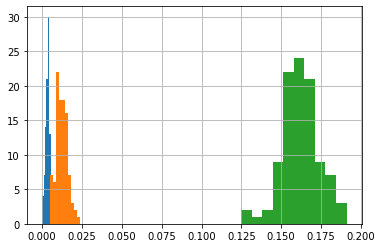

In [78]:
pd.Series(scores_random_search).hist()
pd.Series(scores_weighted_random_search).hist()
pd.Series(scores_nn_search).hist()

# Топ 20 для ряда исполнителей

In [33]:
persons_lst = [
    281542, # The Prodigy
    56683,  # Bowie
    276125, # Pink Floyd
    200082  # Lil Wayne
]
persons[persons['person_id'].isin(persons_lst)]

,person_id,person_name,person_MBID
1373,56683,Bowie,5441c29d-3602-4898-b1a1-b77fa23b8e50
21043,276125,Pink+Floyd+&+Floyd,83d91898-7763-47d7-b03b-b92132375c47
25139,56683,David+Bowie+&+Bing+Crosby,5441c29d-3602-4898-b1a1-b77fa23b8e50
27674,56683,David+Bowie+&+Pet+Shop+Boys,5441c29d-3602-4898-b1a1-b77fa23b8e50
32700,56683,David+Bowie+&+Phillip+Glass,NaN
40008,56683,David+Bowie+&+Trent+Reznor,5441c29d-3602-4898-b1a1-b77fa23b8e50
40030,200082,Lil+Wayne+Feat.+Drake+&+Rick+Ross,NaN
44602,276125,Pink+Floyd+&+The+Orb,83d91898-7763-47d7-b03b-b92132375c47
44799,56683,David+Bowie+&+Pat+Metheny,5441c29d-3602-4898-b1a1-b77fa23b8e50
49995,56683,David+Bowie+&+Freddie+Mercury,5441c29d-3602-4898-b1a1-b77fa23b8e50


In [55]:
top_20 = [(p_id, search_nn(embeddings, embeddings.loc[[p_id]], num_top_elements=20)) for p_id in persons_lst]
top_20 = pd.DataFrame(top_20, columns=['person_id', 'top']).explode('top')
top_20['top'] = top_20['top'].astype(int)
top_20

,person_id,top
0,281542,148559
0,281542,74637
0,281542,87347
0,281542,463333
0,281542,294342
...,...,...
3,200082,8846
3,200082,49227
3,200082,208682
3,200082,173505


In [56]:
persons_uniq = persons.copy()
persons_uniq['person_lenght'] = persons_uniq['person_name'].str.len()
persons_uniq = persons_uniq.sort_values('person_lenght')
persons_uniq = persons_uniq.groupby(['person_id'], as_index=False)['person_name'].first()
persons_uniq

,person_id,person_name
0,0,000003+Music+Instructor
1,1,00-01
2,2,0005.+Overkill
3,3,000C+Tony+Dize
4,4,000+Oscarcito
...,...,...
560922,595136,Kwajbasket+&+Gimu
560923,595137,David+Granha+&+John+Axion
560924,595138,"Tam+Cooper,+Will+Saul"
560925,595139,Cousin+Silas+&+LPF12


In [57]:
top_20_with_names = (top_20
    .merge(persons_uniq, how="left", on=['person_id'])
    .merge(persons_uniq, how="left", left_on=['top'], right_on=['person_id'], suffixes=('', '_neighbour'))
    .drop(columns=['person_id_neighbour'])
)

top_20_with_names

,person_id,top,person_name,person_name_neighbour
0,281542,148559,Prodigy,Fatboy+Slim
1,281542,74637,Prodigy,Chemical+Brothers
2,281542,87347,Prodigy,TCM
3,281542,463333,Prodigy,JXL
4,281542,294342,Prodigy,Richard+Cheese
...,...,...,...,...
75,200082,8846,Lil+Wayne,Ace+Hood
76,200082,49227,Lil+Wayne,Birdman
77,200082,208682,Lil+Wayne,Ludacris
78,200082,173505,Lil+Wayne,Gucci+Mane


### Посмотрим поближе на топ 20 по ряду исполнителей

In [58]:
# Prodigy
top_20_with_names[
    top_20_with_names['person_id'].isin([281542])
]

# Посмотрел похожие на сайте самого last.fm
# https://www.last.fm/ru/music/The+Prodigy/+similar
# 1 страница: TCM, Chemical+Brothers, Fatboy+Slim, JXL, Pendulum
# 2 страница: Moby, Faithless
# 3 страница: Bomfunk+MCs

,person_id,top,person_name,person_name_neighbour
0,281542,148559,Prodigy,Fatboy+Slim
1,281542,74637,Prodigy,Chemical+Brothers
2,281542,87347,Prodigy,TCM
3,281542,463333,Prodigy,JXL
4,281542,294342,Prodigy,Richard+Cheese
5,281542,252583,Prodigy,NIN
6,281542,147287,Prodigy,Faithless
7,281542,322429,Prodigy,Skunk+Anansie
8,281542,55071,Prodigy,Bomfunk+MCs
9,281542,122833,Prodigy,Dub+Fx


In [59]:
# Bowie
top_20_with_names[
    top_20_with_names['person_id'].isin([56683])
]

# Посмотрел похожие на сайте самого last.fm
# https://www.last.fm/ru/music/David+Bowie/+similar
# 1 страница: Iggy, Lou+Reed, Talking+Heads
# 2 страница: John+Lenon, Bob+Dylan
# 3 страница: Kinks, Blondie, Clash, fleetwod+mac
# 4 страница: Peter+Gabriel

,person_id,top,person_name,person_name_neighbour
20,56683,455930,Bowie,Johhny+Cash
21,56683,80485,Bowie,Clash
22,56683,246,Bowie,Beach+Boys
23,56683,438990,Bowie,Iggy
24,56683,272592,Bowie,Peter+Gabriel
25,56683,278529,Bowie,Police
26,56683,53987,Bowie,Bob+Dylan
27,56683,343695,Bowie,Talking+Heads
28,56683,206918,Bowie,Lou+Reed
29,56683,184674,Bowie,Kinks


In [60]:
# Pink Floyd
top_20_with_names[
    top_20_with_names['person_id'].isin([276125])
]

# Посмотрел похожие на сайте самого last.fm
# https://www.last.fm/ru/music/Pink+Floyd/+similar
# 1 страница: Led+Zepplin, King+Crimson, Doors, Jimi+Hendrix, Beatles
# 2 страница: The+Who, Dire+Straits, Genesis
# 3 страница: John+Lenon, Queen, Rolling+Stones

,person_id,top,person_name,person_name_neighbour
40,276125,359758,Pink+Floud,Jimi+Hendrix
41,276125,371939,Pink+Floud,The+Who
42,276125,68459,Pink+Floud,Carlos+Santana
43,276125,196973,Pink+Floud,John+Lenon
44,276125,70915,Pink+Floud,CCR
45,276125,195697,Pink+Floud,Led+Zepplin
46,276125,156875,Pink+Floud,Frank+Zappa
47,276125,114685,Pink+Floud,Dire+Straits
48,276125,354785,Pink+Floud,Doors
49,276125,299571,Pink+Floud,Rolling+Stones


In [61]:
# Lil Wayne
top_20_with_names[
    top_20_with_names['person_id'].isin([200082])
]

# Посмотрел похожие на сайте самого last.fm
# https://www.last.fm/ru/music/Lil%27+Wayne/+similar
# 1 страница: 2+Chainz, T.I., Jeezy, Birdman, Young+Money, Rick+Ross, YG
# 2 страница: Future, DJ+Khaled, Gucci+Mane, Big+Sean
# 3 страница: j.cole, Ace+Hood
# 4 страница: Ludacris, Wale

,person_id,top,person_name,person_name_neighbour
60,200082,161570,Lil+Wayne,Tyga
61,200082,374349,Lil+Wayne,T.I.
62,200082,47600,Lil+Wayne,Big+Sean
63,200082,3165,Lil+Wayne,2+Chainz
64,200082,449356,Lil+Wayne,j.cole
65,200082,420178,Lil+Wayne,DJ+Khaled
66,200082,462060,Lil+Wayne,Juicy+J
67,200082,160331,Lil+Wayne,Future
68,200082,397111,Lil+Wayne,Wale
69,200082,295069,Lil+Wayne,Rick+Ross
